In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader
from tqdm import tqdm 

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")

    
# To REMOOOOOOOOOOOOOOOOOOOOOOOOVE 
#DEVICE = torch.device("cpu")

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    
    
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/home/linuxbrew/.linuxbrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Using GPU!


In [2]:
# Loading the data 
activ = torch.load('/home/meller/Documents/giotto-deep/examples/saves/activ_v5')
model = torch.load('/home/meller/Documents/giotto-deep/examples/saves/model_v5')
activG =torch.load('/home/meller/Documents/giotto-deep/examples/saves/activG_v5')

writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


#cpu = torch.ones(1).device


arch = [28*28,100,50,50,50, 10]
optimizer = torch.optim.SGD
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())


predLabel = torch.zeros(activ.shape[0],activ.shape[1])
for alter in range(activ.shape[0]):
    predLabel[alter] = activ[alter,:,-10:].argmax(dim=1)
    
    
label = torch.zeros(activ[0].shape[0])
k_batch = 0 
for data, target in tqdm(dl_tr):
    label[k_batch*32:(k_batch+1)*32]=target
    k_batch+=1
    if k_batch*32>=activ[0].shape[0]:
        break 

 43%|████████████████▌                      | 799/1875 [00:01<00:02, 401.79it/s]


In [3]:
import os 
os.system('ls')

basic_tutorial_gridsearch_benchmarking.ipynb
basic_tutorial_image.ipynb
basic_tutorial_QandA.ipynb
basic_tutorial_regression.ipynb
basic_tutorial_tabular.ipynb
basic_tutorial_textClass.ipynb
basic_tutorial_translation.ipynb
CNN-SVR.ipynb
compactification.ipynb
data
decision_boundary_tori.ipynb
Ensemble_learning.ipynb
Intersection_Homology.ipynb
kernelAnalysis.ipynb
lapInputLayer
lapInputLayerBin
lapInputLayer.zip
LaplacianSpectralAnalysis.ipynb
LeftRightProblem.ipynb
networkEvolution.ipynb
optimising_topology.ipynb
orbit_5k_train.ipynb
record
reflexiveNetworks.ipynb
rotation_network.ipynb
runs
SafariLinearNets.ipynb
saves
spectral_analysis_cnn.ipynb
TopactivationFC_tutorial.ipynb


0

In [4]:

import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 
import os 


def mode_transform_save(weights,name,nodeColor='blue',sigmaThreshold=3):
    S = []
    V = []
    U = []
    K = []
    for layer in weights:
        u,s,v= torch.svd(layer)
        U.append(u.to('cpu'))
        S.append(s.to('cpu'))
        V.append(v.to('cpu'))

    adjacency = [V[i+1].T@U[i] for i in range(len(V)-1)]



    def y_scale(x):
        return x 
        return (x-0.4)**0.2

    df = pd.DataFrame({})
    fig = px.scatter(df)


    #Edges  
    for k in range(len(adjacency)):
        E2=torch.abs(adjacency[k])
        for i in range(E2.shape[0]):
            for j in range(E2.shape[1]):
                Emin = sigmaThreshold*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
                if E2[i,j]>Emin:
                    edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                    #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')

                    #fig.add_trace(figEdge)
                    coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                    color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                    r,g,b=int(color[0]),int(color[1]),int(color[2])
                    color = "rgb"+str((r,g,b))
                    fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":1},hovertext=str(adjacency[k][i,j])
                                   ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 

                    middle_node_trace = go.Scatter(
                        x=[np.array(edge["x"]).mean()],
                        y=[np.array(edge["y"]).mean()],
                        text=[str(adjacency[k][i,j])],
                        mode='markers',
                        hoverinfo='text',
                        showlegend=False,
                        marker=go.scatter.Marker(
                            opacity=0,
                            color='lightgrey'
                        )
                    )

                    fig.add_trace(middle_node_trace)




    base=0
    for i in range (len(S)):
        layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i])})
        df = pd.concat([df,layer_i])
        base+=len(S[i])


    #fig.add_scatter(x=df["x"], y=df["y"])           
    node_trace = go.Scatter(
        x=df["x"],
        y=df["y"],
        mode='markers',
        showlegend=False,
        marker=go.scatter.Marker(
            opacity=1,
            color = nodeColor
        ))

    fig.add_trace(node_trace)

    #fig.show()
    fig.write_image("record/"+name+'.png')
    return U,S,V


def mode_transform(weights,sigmaThreshold=3):
    S = []
    V = []
    U = []
    K = []
    for layer in weights:
        u,s,v= torch.svd(layer)
        U.append(u.to('cpu'))
        S.append(s.to('cpu'))
        V.append(v.to('cpu'))

    adjacency = [V[i+1].T@U[i] for i in range(len(arch)-2)]



    def y_scale(x):
        return x 
        return (x-0.4)**0.2

    df = pd.DataFrame({})
    fig = px.scatter(df)


    #Edges  
    for k in range(len(adjacency)):
        E2=torch.abs(adjacency[k])
        for i in range(E2.shape[0]):
            for j in range(E2.shape[1]):
                Emin = sigmaThreshold*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
                if E2[i,j]>Emin:
                    edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                    #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')

                    #fig.add_trace(figEdge)
                    coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                    color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                    r,g,b=int(color[0]),int(color[1]),int(color[2])
                    color = "rgb"+str((r,g,b))
                    fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":1},hovertext=str(adjacency[k][i,j])
                                   ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 

                    middle_node_trace = go.Scatter(
                        x=[np.array(edge["x"]).mean()],
                        y=[np.array(edge["y"]).mean()],
                        text=[str(adjacency[k][i,j])],
                        mode='markers',
                        hoverinfo='text',
                        showlegend=False,
                        marker=go.scatter.Marker(
                            opacity=0,
                            color='lightgrey'
                        )
                    )

                    fig.add_trace(middle_node_trace)




    base=0
    for i in range (len(S)):
        layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i])})
        df = pd.concat([df,layer_i])
        base+=len(S[i])


    #fig.add_scatter(x=df["x"], y=df["y"])           
    node_trace = go.Scatter(
        x=df["x"],
        y=df["y"],
        mode='markers',
        showlegend=False,
        marker=go.scatter.Marker(
            opacity=1,
        ))

    fig.add_trace(node_trace)

    fig.show()
    return U,S,V


In [5]:
res = mode_transform_save([torch.rand(4,5),torch.rand(8,4),torch.rand(40,8),torch.rand(10,40)],'test')

In [6]:
#from gdeep.data import DataLoaderFromArray -> Useless 


from foolbox import PyTorchModel
from foolbox.attacks import L2FastGradientAttack
atkFGM = L2FastGradientAttack()
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
from gdeep.topactivation.svr import SVR

import os 

def train_record_new_model(model,X,y,folder,epochs=5,epochs_adv=[],record=False):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=32


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    #model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    atkFGM = L2FastGradientAttack()
    epsilons=[2.0]
    
    if not os.path.exists('record/'+folder):
        os.mkdir('record/'+folder)
        
        
    n_batch = len(X_train)//batch_size
    print("Number of batch per epoch : ",n_batch)
    
    L1 = torch.zeros((n_batch*epochs,len(arch)-2))
    Entropy = torch.zeros((n_batch*epochs,len(arch)-2))
    PM = torch.zeros((n_batch*epochs))

    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(n_batch)):
            data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
         
            weights = [A.detach() for A in list(model.parameters())]
            name = 'record/'+folder+'/'+str(epoch)+'_'+str(batch_idx)

            svr = SVR(weights)
            if record:
                if epoch in epochs_adv:
                    svr.plot_save(name,nodeColor='red')
                else:
                    svr.plot_save(name,nodeColor='blue')
            L1[epoch*n_batch+batch_idx]= svr.L1()
            Entropy[epoch*n_batch+batch_idx]= svr.entropy()
            PM[epoch*n_batch+batch_idx] = svr.pathmetric(svdThreshold=1)

            
            
            if epoch in epochs_adv:
                fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=None)
                _,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
                data=clipped_atk[0]

            
            
         
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = loss_fn(output, target)
            
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model,L1,Entropy,PM

In [7]:
#Vanilla test 
m = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
m,L1,Entropy,PM= train_record_new_model(m,activ[0][:,:28*28],label,'m2',epochs=7,epochs_adv=[6])

Number of batch per epoch :  770


100%|█████████████████████████████████████████| 770/770 [00:16<00:00, 47.03it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  55.27597402597403  %
Test Accuracy :  88.4375  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 49.25it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  92.19967532467533  %
Test Accuracy :  94.375  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 50.91it/s]


---------------  Epoch :  2  ---------------
Train Accuracy :  95.11363636363637  %
Test Accuracy :  95.10416666666667  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 51.33it/s]


---------------  Epoch :  3  ---------------
Train Accuracy :  96.47321428571428  %
Test Accuracy :  95.83333333333334  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 51.04it/s]


---------------  Epoch :  4  ---------------
Train Accuracy :  97.30925324675324  %
Test Accuracy :  95.52083333333333  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 51.00it/s]


---------------  Epoch :  5  ---------------
Train Accuracy :  97.93425324675324  %
Test Accuracy :  95.41666666666667  %


  0%|                                                   | 0/770 [00:00<?, ?it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

  4%|█▌                                        | 29/770 [00:00<00:16, 45.25it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  8%|███▏                                      | 59/770 [00:01<00:15, 45.72it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 12%|████▊                                     | 89/770 [00:01<00:15, 45.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 15%|██████▎                                  | 119/770 [00:02<00:14, 44.86it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deter

 23%|█████████▎                               | 174/770 [00:03<00:13, 44.84it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 26%|██████████▊                              | 204/770 [00:04<00:12, 44.55it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 30%|████████████▍                            | 234/770 [00:05<00:11, 44.68it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 34%|██████████████                           | 264/770 [00:05<00:11, 45.13it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 38%|███████████████▋                         | 294/770 [00:06<00:10, 44.99it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 42%|█████████████████▎                       | 324/770 [00:07<00:09, 44.61it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deter

 49%|████████████████████▏                    | 379/770 [00:08<00:08, 44.71it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 53%|█████████████████████▊                   | 409/770 [00:09<00:08, 44.77it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 57%|███████████████████████▍                 | 439/770 [00:09<00:07, 45.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 61%|████████████████████████▉                | 469/770 [00:10<00:06, 44.76it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 65%|██████████████████████████▌              | 499/770 [00:11<00:05, 45.31it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 69%|████████████████████████████▏            | 529/770 [00:11<00:05, 44.70it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 73%|█████████████████████████████▊           | 559/770 [00:12<00:04, 45.35it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 76%|███████████████████████████████▎         | 589/770 [00:13<00:04, 44.81it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 80%|████████████████████████████████▉        | 619/770 [00:13<00:03, 44.53it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deter

 88%|███████████████████████████████████▉     | 674/770 [00:15<00:02, 44.83it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 91%|█████████████████████████████████████▍   | 704/770 [00:15<00:01, 45.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 95%|███████████████████████████████████████  | 734/770 [00:16<00:00, 44.75it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 99%|████████████████████████████████████████▋| 764/770 [00:17<00:00, 44.93it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: User

---------------  Epoch :  6  ---------------
Train Accuracy :  59.991883116883116  %
Test Accuracy :  91.04166666666667  %


In [8]:
def pathmetric(U,S0,V,svdThreshold=0,svdScale=True):
    adjacency = [torch.abs(V[i+1].T@U[i]) for i in range(len(V)-1)]
    device = U[0].device
    
    if svdScale:
        S = [s.copy() for s in S0]
    else: 
        S = [torch.ones(len(s)) for s in S0]
        
    S = [S[i]*(s>svdThreshold) for i,s in enumerate(S0) ]
    
    x = torch.ones(len(S[0])).to(device)
    for i in range(len(S)-1):
        x=x*S[i]
        x = adjacency[i]@x
    x = x*S[-1]
    return x.sum().item()

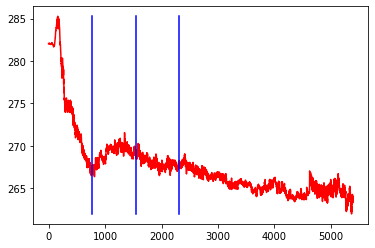

In [9]:
# Analysis of F1 norm : 
n_batch=770

i = 2
plt.plot(L1[:,i],color='red')
for k in range(3):
    plt.plot(2*[(k+1)*n_batch],[L1[:,i].min(),L1[:,i].max()],color='blue')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


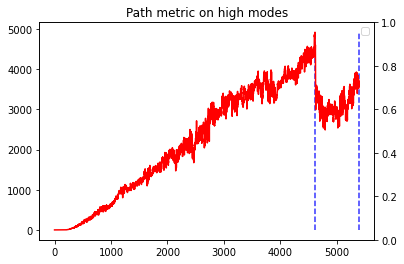

In [10]:
# Path metric
n_batch=770
import numpy as np 
ax1 = plt.subplot()


for k in range(5,7):
    l1, = ax1.plot(2*[(k+1)*n_batch],[PM.min(),PM.max()],'--',alpha=0.8,color='blue')
    

l1 = ax1.plot(PM,color='red',label='Pathmetric')
plt.title('Path metric on high modes')

# 0 train acc, 1 test acc 
ax2 = ax1.twinx()


acc = torch.tensor([[58.8,92.08, 95.15, 96.5 , 97.3, 97.88,60],
                    [ 88.6,93.7,95.4, 95.2,95,95.7,89]])
#l2, = ax2.plot(np.array(range(7))*770+770/2,acc[1], color='orange')
plt.legend()
plt.show()

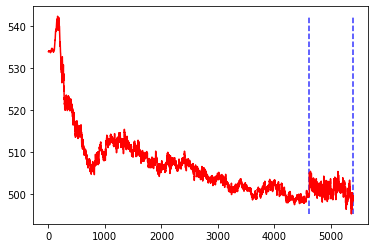

In [11]:
# Analysis of entropy 
i = 2

for k in range(5,7):
    plt.plot(2*[(k+1)*n_batch],[Entropy[:,i].min(),Entropy[:,i].max()],'--',alpha=0.8,color='blue')
    
plt.plot(Entropy[:,i],color='red')
plt.plot()
plt.show()



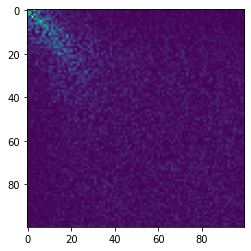

In [12]:
# Gram matrix between adversarially trained and normal : 


    
A = next(model.parameters())
A2 = next(m.parameters())
_,_,V=torch.svd(A)
_,_,V2=torch.svd(A2)
im = torch.abs(V2.T@V)
plt.imshow(im.to('cpu').detach())

In [13]:
weights_model = [A.detach().to('cpu') for A in model.parameters()]
weights_m = [A.detach().to('cpu') for A in m.parameters()]
#_ = mode_transform(weights_model)

7.8354268074035645
E_blue :  0.030019322410225868
E_red :  0.05460483580827713


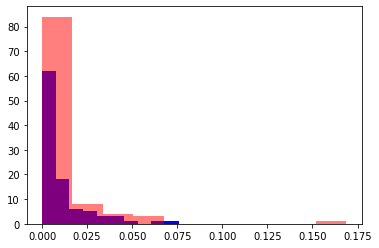

In [14]:
def adjacency_0(w):

    u,_,_= torch.svd(w[0])
    _,s,v= torch.svd(w[1])

    return torch.abs(v.T@u),s
adja1,s1 = adjacency_0(weights_model)
adja2,s2 = adjacency_0(weights_m)

idx = 4
plt.hist(adja1[idx,:].numpy()**2,color='blue')
plt.hist(adja2[idx,:].numpy()**2,color='red',alpha=0.5)
print(adja1[idx,:].sum().item())
print("E_blue : ", (adja1[idx,:]**4).sum().item() ) 
print("E_red : ", (adja2[idx,:]**4).sum().item() ) 
plt.show()

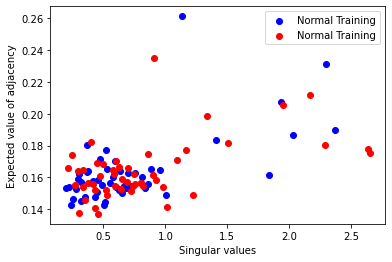

In [15]:
blue =[]
red = []
for idx in range(adja1.shape[0]):
    blue.append(((adja1[idx,:]**3).sum().item()))
    red.append(((adja2[idx,:]**3).sum().item()))
plt.scatter(s1,blue,color='blue',label='Normal Training')
plt.scatter(s2,red,color='red',label='Normal Training')
plt.xlabel('Singular values')
plt.ylabel('Expected value of adjacency')
plt.legend()

In [16]:
adja1.shape

torch.Size([50, 100])

In [17]:
mfgsm= train_record_new_model(m,activ[1][:,:28*28],label,folder='m0-fgsm',epochs=3)

Number of batch per epoch :  770


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 50.80it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  94.00974025974025  %
Test Accuracy :  98.4375  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 50.87it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  99.05032467532467  %
Test Accuracy :  98.125  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 50.88it/s]

---------------  Epoch :  2  ---------------
Train Accuracy :  99.46428571428572  %
Test Accuracy :  99.375  %


In [18]:
mcarlini= train_record_new_model(m,activ[3][:,:28*28],label,folder='m0-carlini',epochs=3)

Number of batch per epoch :  770


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 50.86it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  95.81168831168831  %
Test Accuracy :  96.97916666666667  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 50.89it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  97.34172077922078  %
Test Accuracy :  97.5  %


100%|█████████████████████████████████████████| 770/770 [00:15<00:00, 50.87it/s]

---------------  Epoch :  2  ---------------
Train Accuracy :  98.08441558441558  %
Test Accuracy :  96.04166666666667  %


In [19]:
#from gdeep.data import DataLoaderFromArray -> Useless 

from foolbox import PyTorchModel
from foolbox.attacks import L2FastGradientAttack
atkFGM = L2FastGradientAttack()

def train_attack1s2_record_new_model(arch,X,y,folder,epochs=5):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=32


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    atkFGM = L2FastGradientAttack()
    epsilons=[2.0]
    
    if not os.path.exists('record/'+folder):
        os.mkdir('record/'+folder)
    
    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(len(X_train)//batch_size)):
            data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

                
            weights = [A.detach() for A in list(model.parameters())]
            name = folder+'/'+str(epoch)+'_'+str(batch_idx)
            
            
            if epoch%2==1:
                res = mode_transform_save(weights,name,nodeColor='red')
                
                fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=None)
                _,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
                data=clipped_atk[0]
                
            else:
                res = mode_transform_save(weights,name)
            
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model 

In [20]:
m1s2 =train_attack1s2_record_new_model(arch,activ[0][:,:28*28],label,'m1s2',epochs=4)

100%|█████████████████████████████████████████| 770/770 [05:27<00:00,  2.35it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  57.84902597402597  %
Test Accuracy :  89.16666666666667  %


  0%|                                                   | 0/770 [00:00<?, ?it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  0%|                                           | 1/770 [00:00<05:33,  2.30it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  0%|                                           | 2/770 [00:00<05:43,  2.24it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  3%|█▎                                        | 24/770 [00:11<06:34,  1.89it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  3%|█▎                                        | 25/770 [00:11<06:20,  1.96it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  3%|█▍                                        | 26/770 [00:12<06:11,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  6%|██▌                                       | 48/770 [00:23<05:39,  2.13it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  6%|██▋                                       | 49/770 [00:23<05:45,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  6%|██▋                                       | 50/770 [00:23<05:47,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  9%|███▉                                      | 72/770 [00:34<05:30,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  9%|███▉                                      | 73/770 [00:35<05:33,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 10%|████                                      | 74/770 [00:35<05:33,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 12%|█████▏                                    | 96/770 [00:46<05:32,  2.03it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 13%|█████▎                                    | 97/770 [00:46<05:29,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 13%|█████▎                                    | 98/770 [00:47<05:28,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 16%|██████▍                                  | 120/770 [00:58<05:13,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 16%|██████▍                                  | 121/770 [00:58<05:12,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 16%|██████▍                                  | 122/770 [00:59<05:15,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 19%|███████▋                                 | 144/770 [01:10<05:19,  1.96it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 19%|███████▋                                 | 145/770 [01:10<05:16,  1.98it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 19%|███████▊                                 | 146/770 [01:11<05:08,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 22%|████████▉                                | 168/770 [01:21<04:53,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 22%|████████▉                                | 169/770 [01:22<04:48,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 22%|█████████                                | 170/770 [01:22<04:46,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 25%|██████████▏                              | 192/770 [01:33<04:40,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 25%|██████████▎                              | 193/770 [01:34<04:40,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 25%|██████████▎                              | 194/770 [01:34<04:39,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 28%|███████████▌                             | 216/770 [01:45<04:50,  1.91it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 28%|███████████▌                             | 217/770 [01:46<04:45,  1.94it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 28%|███████████▌                             | 218/770 [01:46<04:39,  1.97it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 31%|████████████▊                            | 240/770 [01:57<04:18,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 31%|████████████▊                            | 241/770 [01:58<04:14,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 31%|████████████▉                            | 242/770 [01:58<04:10,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 34%|██████████████                           | 264/770 [02:09<04:10,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 34%|██████████████                           | 265/770 [02:09<04:09,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 35%|██████████████▏                          | 266/770 [02:10<04:05,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 37%|███████████████▎                         | 288/770 [02:21<04:09,  1.93it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 38%|███████████████▍                         | 289/770 [02:21<04:04,  1.96it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 38%|███████████████▍                         | 290/770 [02:22<03:59,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 41%|████████████████▌                        | 312/770 [02:32<03:40,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 41%|████████████████▋                        | 313/770 [02:33<03:38,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 41%|████████████████▋                        | 314/770 [02:33<03:38,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 44%|█████████████████▉                       | 336/770 [02:44<03:28,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 44%|█████████████████▉                       | 337/770 [02:44<03:27,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 44%|█████████████████▉                       | 338/770 [02:45<03:26,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 47%|███████████████████▏                     | 360/770 [02:55<03:23,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 47%|███████████████████▏                     | 361/770 [02:56<03:19,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 47%|███████████████████▎                     | 362/770 [02:56<03:17,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 50%|████████████████████▍                    | 384/770 [03:07<03:05,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 50%|████████████████████▌                    | 385/770 [03:08<03:04,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 50%|████████████████████▌                    | 386/770 [03:08<03:06,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 53%|█████████████████████▋                   | 408/770 [03:19<03:12,  1.88it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 53%|█████████████████████▊                   | 409/770 [03:19<03:09,  1.91it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 53%|█████████████████████▊                   | 410/770 [03:20<03:06,  1.93it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 56%|███████████████████████                  | 432/770 [03:31<02:45,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 56%|███████████████████████                  | 433/770 [03:31<02:42,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 56%|███████████████████████                  | 434/770 [03:32<02:40,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 59%|████████████████████████▎                | 456/770 [03:42<02:31,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 59%|████████████████████████▎                | 457/770 [03:43<02:30,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 59%|████████████████████████▍                | 458/770 [03:43<02:31,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 62%|█████████████████████████▌               | 480/770 [03:54<02:24,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 62%|█████████████████████████▌               | 481/770 [03:55<02:23,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 63%|█████████████████████████▋               | 482/770 [03:55<02:22,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 65%|██████████████████████████▊              | 504/770 [04:06<02:10,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 66%|██████████████████████████▉              | 505/770 [04:07<02:11,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 66%|██████████████████████████▉              | 506/770 [04:07<02:09,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 69%|████████████████████████████             | 528/770 [04:18<02:00,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 69%|████████████████████████████▏            | 529/770 [04:18<01:59,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 69%|████████████████████████████▏            | 530/770 [04:19<01:59,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 72%|█████████████████████████████▍           | 552/770 [04:30<01:47,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 72%|█████████████████████████████▍           | 553/770 [04:30<01:47,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 72%|█████████████████████████████▍           | 554/770 [04:31<01:45,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 75%|██████████████████████████████▋          | 576/770 [04:42<01:35,  2.03it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 75%|██████████████████████████████▋          | 577/770 [04:42<01:34,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 75%|██████████████████████████████▊          | 578/770 [04:43<01:33,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 78%|███████████████████████████████▉         | 600/770 [04:53<01:24,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 78%|████████████████████████████████         | 601/770 [04:54<01:24,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 78%|████████████████████████████████         | 602/770 [04:54<01:23,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 81%|█████████████████████████████████▏       | 624/770 [05:05<01:09,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 81%|█████████████████████████████████▎       | 625/770 [05:06<01:08,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 81%|█████████████████████████████████▎       | 626/770 [05:06<01:08,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 84%|██████████████████████████████████▌      | 648/770 [05:17<01:01,  1.99it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 84%|██████████████████████████████████▌      | 649/770 [05:18<01:00,  1.99it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 84%|██████████████████████████████████▌      | 650/770 [05:18<01:00,  1.99it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 87%|███████████████████████████████████▊     | 672/770 [05:29<00:50,  1.96it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 87%|███████████████████████████████████▊     | 673/770 [05:30<00:48,  1.99it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 88%|███████████████████████████████████▉     | 674/770 [05:30<00:48,  1.98it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 90%|█████████████████████████████████████    | 696/770 [05:42<00:38,  1.91it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 91%|█████████████████████████████████████    | 697/770 [05:42<00:38,  1.90it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 91%|█████████████████████████████████████▏   | 698/770 [05:43<00:38,  1.87it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 94%|██████████████████████████████████████▎  | 720/770 [05:54<00:26,  1.89it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 94%|██████████████████████████████████████▍  | 721/770 [05:55<00:25,  1.91it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 94%|██████████████████████████████████████▍  | 722/770 [05:55<00:25,  1.91it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 97%|███████████████████████████████████████▌ | 744/770 [06:07<00:13,  1.90it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 97%|███████████████████████████████████████▋ | 745/770 [06:07<00:13,  1.91it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 97%|███████████████████████████████████████▋ | 746/770 [06:08<00:12,  1.92it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

100%|████████████████████████████████████████▉| 768/770 [06:19<00:00,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

100%|████████████████████████████████████████▉| 769/770 [06:19<00:00,  1.90it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

100%|█████████████████████████████████████████| 770/770 [06:20<00:00,  2.02it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  55.53977272727273  %
Test Accuracy :  85.83333333333333  %


100%|█████████████████████████████████████████| 770/770 [06:16<00:00,  2.05it/s]


---------------  Epoch :  2  ---------------
Train Accuracy :  94.41964285714286  %
Test Accuracy :  96.14583333333333  %


  0%|                                                   | 0/770 [00:00<?, ?it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  0%|                                           | 1/770 [00:00<06:30,  1.97it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  0%|                                           | 2/770 [00:00<06:10,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  3%|█▎                                        | 24/770 [00:11<06:04,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  3%|█▎                                        | 25/770 [00:12<06:32,  1.90it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  3%|█▍                                        | 26/770 [00:12<06:23,  1.94it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  6%|██▌                                       | 48/770 [00:23<05:43,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  6%|██▋                                       | 49/770 [00:23<05:48,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  6%|██▋                                       | 50/770 [00:24<05:52,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  9%|███▉                                      | 72/770 [00:35<05:38,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  9%|███▉                                      | 73/770 [00:35<05:41,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 10%|████                                      | 74/770 [00:36<05:37,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 12%|█████▏                                    | 96/770 [00:46<05:20,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 13%|█████▎                                    | 97/770 [00:46<05:18,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 13%|█████▎                                    | 98/770 [00:47<05:21,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 16%|██████▍                                  | 120/770 [00:58<05:18,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 16%|██████▍                                  | 121/770 [00:58<05:16,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 16%|██████▍                                  | 122/770 [00:59<05:19,  2.03it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 19%|███████▋                                 | 144/770 [01:09<05:28,  1.90it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 19%|███████▋                                 | 145/770 [01:10<05:20,  1.95it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 19%|███████▊                                 | 146/770 [01:10<05:15,  1.97it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 22%|████████▉                                | 168/770 [01:21<04:51,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 22%|████████▉                                | 169/770 [01:21<04:49,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 22%|█████████                                | 170/770 [01:22<04:50,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 25%|██████████▏                              | 192/770 [01:32<04:23,  2.19it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 25%|██████████▎                              | 193/770 [01:32<04:25,  2.17it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 25%|██████████▎                              | 194/770 [01:33<04:28,  2.15it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 28%|███████████▌                             | 216/770 [01:43<04:10,  2.21it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 28%|███████████▌                             | 217/770 [01:44<04:10,  2.21it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 28%|███████████▌                             | 218/770 [01:44<04:10,  2.21it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 31%|████████████▊                            | 240/770 [01:54<04:05,  2.16it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 31%|████████████▊                            | 241/770 [01:55<04:10,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 31%|████████████▉                            | 242/770 [01:55<04:07,  2.14it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 34%|██████████████                           | 264/770 [02:06<03:59,  2.12it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 34%|██████████████                           | 265/770 [02:06<03:58,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 35%|██████████████▏                          | 266/770 [02:07<04:03,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 37%|███████████████▎                         | 288/770 [02:17<03:44,  2.14it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 38%|███████████████▍                         | 289/770 [02:18<03:41,  2.17it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 38%|███████████████▍                         | 290/770 [02:18<03:41,  2.17it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 41%|████████████████▌                        | 312/770 [02:28<03:37,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 41%|████████████████▋                        | 313/770 [02:29<03:36,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 41%|████████████████▋                        | 314/770 [02:29<03:54,  1.94it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 44%|█████████████████▉                       | 336/770 [02:40<03:23,  2.13it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 44%|█████████████████▉                       | 337/770 [02:40<03:24,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 44%|█████████████████▉                       | 338/770 [02:41<03:25,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 47%|███████████████████▏                     | 360/770 [02:51<03:20,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 47%|███████████████████▏                     | 361/770 [02:52<03:16,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 47%|███████████████████▎                     | 362/770 [02:52<03:16,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 50%|████████████████████▍                    | 384/770 [03:03<03:07,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 50%|████████████████████▌                    | 385/770 [03:03<03:05,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 50%|████████████████████▌                    | 386/770 [03:04<03:04,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 53%|█████████████████████▋                   | 408/770 [03:14<02:51,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 53%|█████████████████████▊                   | 409/770 [03:15<02:50,  2.12it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 53%|█████████████████████▊                   | 410/770 [03:15<02:50,  2.12it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 56%|███████████████████████                  | 432/770 [03:26<02:41,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 56%|███████████████████████                  | 433/770 [03:26<02:38,  2.12it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 56%|███████████████████████                  | 434/770 [03:27<02:39,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 59%|████████████████████████▎                | 456/770 [03:37<02:26,  2.14it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 59%|████████████████████████▎                | 457/770 [03:37<02:26,  2.13it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 59%|████████████████████████▍                | 458/770 [03:38<02:27,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 62%|█████████████████████████▌               | 480/770 [03:49<02:27,  1.96it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 62%|█████████████████████████▌               | 481/770 [03:49<02:24,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 63%|█████████████████████████▋               | 482/770 [03:50<02:22,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 65%|██████████████████████████▊              | 504/770 [04:00<02:08,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 66%|██████████████████████████▉              | 505/770 [04:01<02:07,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 66%|██████████████████████████▉              | 506/770 [04:01<02:08,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 69%|████████████████████████████             | 528/770 [04:12<01:59,  2.03it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 69%|████████████████████████████▏            | 529/770 [04:12<01:57,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 69%|████████████████████████████▏            | 530/770 [04:13<01:56,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 72%|█████████████████████████████▍           | 552/770 [04:24<01:46,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 72%|█████████████████████████████▍           | 553/770 [04:24<01:45,  2.06it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 72%|█████████████████████████████▍           | 554/770 [04:25<01:44,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 75%|██████████████████████████████▋          | 576/770 [04:35<01:33,  2.07it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 75%|██████████████████████████████▋          | 577/770 [04:36<01:31,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 75%|██████████████████████████████▊          | 578/770 [04:36<01:32,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 78%|███████████████████████████████▉         | 600/770 [04:47<01:24,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 78%|████████████████████████████████         | 601/770 [04:48<01:23,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 78%|████████████████████████████████         | 602/770 [04:48<01:23,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 81%|█████████████████████████████████▏       | 624/770 [04:59<01:11,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 81%|█████████████████████████████████▎       | 625/770 [04:59<01:10,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 81%|█████████████████████████████████▎       | 626/770 [05:00<01:11,  2.02it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 84%|██████████████████████████████████▌      | 648/770 [05:11<01:00,  2.01it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 84%|██████████████████████████████████▌      | 649/770 [05:11<01:00,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 84%|██████████████████████████████████▌      | 650/770 [05:12<01:00,  1.98it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 87%|███████████████████████████████████▊     | 672/770 [05:23<00:49,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 87%|███████████████████████████████████▊     | 673/770 [05:24<00:48,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 88%|███████████████████████████████████▉     | 674/770 [05:24<00:48,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 90%|█████████████████████████████████████    | 696/770 [05:35<00:37,  1.97it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 91%|█████████████████████████████████████    | 697/770 [05:35<00:36,  1.99it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 91%|█████████████████████████████████████▏   | 698/770 [05:36<00:36,  1.97it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 94%|██████████████████████████████████████▎  | 720/770 [05:47<00:25,  1.97it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 94%|██████████████████████████████████████▍  | 721/770 [05:48<00:24,  1.98it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 94%|██████████████████████████████████████▍  | 722/770 [05:48<00:24,  1.99it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 97%|███████████████████████████████████████▌ | 744/770 [05:59<00:12,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 97%|███████████████████████████████████████▋ | 745/770 [06:00<00:11,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 97%|███████████████████████████████████████▋ | 746/770 [06:00<00:11,  2.08it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

100%|████████████████████████████████████████▉| 768/770 [06:11<00:00,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

100%|████████████████████████████████████████▉| 769/770 [06:11<00:00,  2.15it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

100%|█████████████████████████████████████████| 770/770 [06:12<00:00,  2.07it/s]

---------------  Epoch :  3  ---------------
Train Accuracy :  64.08279220779221  %
Test Accuracy :  92.39583333333333  %


In [21]:
weights1 = [A.detach() for A in list(m.parameters())]
weights2 = [A.detach() for A in list(m1s2.parameters())]

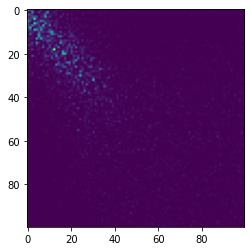

In [22]:
# Gram matrix of input 
_,_,Vi = torch.svd(weights1[0])
_,_,Vj = torch.svd(weights2[0])
Vi,Vj = Vi.to('cpu'),Vj.to('cpu')
gram = Vi.T@Vj
plt.imshow((gram**2))
plt.show()

## Knit nets record 

In [23]:
model = KnitNet(coeff,arch,bias=False,device=DEVICE)
model.linears[1](model.linears[0](torch.eye(arch[0]).to(DEVICE)))

NameError: name 'KnitNet' is not defined

In [ ]:
class KnitNet(nn.Module):
    """This is the class to build a custom feed
    forward reflexive network that is easily built from an array,
    in which the number and dimensions of the layers is specified.

    Args:
        arch (list of int or 1d array, default=[2,3,3,2]):
            this is the list containing the dimension of the layers
            inside your network. all laysers have ``relu`` except for
            the last one which has ``sigmoid`` as activation function.
            The first number is the dimension of the input! Thhe final
            of the output
        it : number of iteration (encoder / decoder)"""
    def __init__(self, coeff,arch=(2, 3, 3, 2),bias=True,device='cpu'):
        super(KnitNet, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(arch[i], arch[i+1],bias=bias).to(device) for i in range(len(arch)-1)])
        self.coeff = coeff 
        
    def feature_loss(self):
        loss = 0
        for i in range(len(self.linears)-1):
            loss+= model.linears[i+1](model.linears[i](torch.eye(arch[i]).to(DEVICE))).norm()
        return loss 
    
    
    def forward(self,x):
        for i, l in enumerate(self.linears[:-1]):
            x = F.relu(l(x))
        x = self.linears[-1](x)
        return x
    
    
    
    
import torch.nn.functional as F

def training_knit(coeff,training = [0,3,0],arch = [784,100,50,50,50,10]):

    """      
     0 : # of epoch for normal training
     1 : # of epoch for both orthogonal and normal
     2 : # epoch for pure orthogonal """
    model = KnitNet(coeff,arch,bias=False,device=DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss()
    
    for phase,epochs in enumerate(training): 
        print(10*'-'+' Phase : '+str(phase)+' '+10*'-')
        for epoch in range(epochs):
            correct_pred = 0
            total_pred = 0
            model.train()
            for batch_idx, (data, target) in enumerate(dl_tr):
                data = data.view([-1, 784]).to(DEVICE)
                target = target.to(DEVICE)

                optimizer.zero_grad()

                if phase==0:
                    output = model(data)
                    loss = loss_fn(output, target)

                elif phase==1:
                    output = model(data)
                    loss1 = loss_fn(output, target)
                    loss2 = model.feature_loss()
                    loss = loss1+loss2
                elif phase==2:
                    loss = model.feature_loss()
                    output = model(data)
                loss.backward()
                optimizer.step()


                correct_pred+=(output.argmax(dim=1)==target).sum().item()
                total_pred += data.shape[0]
            print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
            print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
            model.eval()
            correct_pred = 0
            total_pred = 0
            for batch_idx, (data, target) in enumerate(dl_ts):
                data = data.view([-1, 784]).to(DEVICE)
                target = target.to(DEVICE)

                output = model(data)


                correct_pred+=(output.argmax(dim=1)==target).sum().item()
                total_pred += data.shape[0]

            print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model 


def test(model,X,y):
    output = model(X.to(DEVICE))
    pred=output.argmax(dim=1).to('cpu')
    return ((pred==y).sum()/X.shape[0]*100).item()

In [ ]:
# weights should be loaded before 
ortho_models=[]
for i,config in enumerate([[0,2,0]]+[[0,0,2]]+[[0,2,0]]+[[0,0,2]]):
    if i in [0,1]:
        coeff = 300 
    else:
        coeff = -300
    ortho_models.append(training_knit(coeff,training = config))

In [ ]:



normal = []
fgsm = []
noise = []
for idModel in range(len(ortho_models)):
    normal.append(test(ortho_models[idModel],activ[0][:,:28*28],label))
    fgsm.append(test(ortho_models[idModel],activ[1][:,:28*28],label))
    noise.append(test(ortho_models[idModel],activ[2][:,:28*28],label))
    
plt.plot(normal,label='Normal MNIST')
plt.plot(fgsm,label='FGSM on MNIST')
plt.plot(noise,label='Noise on MNIST')
plt.legend()
plt.show()

In [ ]:
arch

In [ ]:
weights_ortho=[]
for model in ortho_models:
    weights_ortho.append([A.detach() for A in list(model.parameters())])

_,_,Vi = torch.svd(weights_ortho[0][2])
_,_,Vj = torch.svd(weights_ortho[0][3])
Vi,Vj = Vi.to('cpu'),Vj.to('cpu')
gram = Vi.T@Vj
plt.imshow((gram**2))
plt.show()

In [ ]:
_ = mode_transform(weights_ortho[2])